<a href="https://colab.research.google.com/github/fressbish/Koptev-Dmitry/blob/main/task2_Koptev_Dmitry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Коптев Дмитрий
# Задача 2


https://github.com/rustam-azimov/graph-course-itmo/blob/main/tasks/task2.md

In [1]:
# pip install python-graphblas[default]

In [2]:
# pip install colorama

In [3]:
import numpy as np
import pandas as pd
import random
import networkx as nx
import matplotlib.pyplot as plt
import graphblas as gb
from graphblas import Matrix, Vector, Scalar
from graphblas import dtypes
from graphblas import unary, binary, monoid, semiring
from graphblas.io import mmread
from colorama import Style

## MSBFS-Levels

 Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Levels) в ширину из нескольких заданных стартовых вершин.
 - Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
 - Функция возвращает массив пар: стартовая вершина, и массив (levels), где для каждой вершины указано, на каком уровне она достижима из этой стартовой.
 Стартовая вершина достижима на нулевом уровне, если вершина не достижима, то значение соответствующей ячейки сделайте равной -1.

In [4]:
def MSBFS_Levels(A, s):

    # проверим граф на ориентированность
    if A.nvals>0 and A.isequal(A.T):
        return 'Неориентированный граф'

    n = A.nrows
    m = s.size
    # построение матрицы
    result = Matrix(dtypes.INT32, m, n)
    f = Matrix(bool, m, n) # frontier
    succ = Vector(bool, m)
    for i in range(m):
        f[i,s[i]] << True

    level=0 # level in BFS traversal
    while True:
      # depth level
      result(mask=f.V) << level
      # next frontier
      f(~result.S, replace=True) << f.mxm(A, semiring.lor_land)

      true_false = True
      for i in range(m):
          # If next frontier is empty, we're done
          succ[i] << f[i,:].reduce(monoid.lor, allow_empty=False)
          if succ[i]:
            true_false = False
            break
      if true_false:
          break
      level += 1

    # Результат
    res = {}
    for i in range(m):
        values=[]
        for j in range(n):
            if result[i,j].value is None:
              # для недостижимых вершин значение -1
              values.append(-1)
            else:
                values.append(result[i,j].value)
        res[s[i]]=np.array(values)
    return res

## MSBFS-Parents

Используя python-graphblas реализовать функцию обхода ориентированного графа (MSBFS-Parents) в ширину из нескольких заданных стартовых вершин.
- Функция принимает представление графа, удобное для неё (загрузка, конвертация реализованы отдельно) и массив номеров стартовых вершин.
- Функция возвращает массив пар: стартовая вершина, и массив (parents), где для каждой вершины графа указано, из какой вершины мы пришли в эту по кратчайшему пути из стартовой вершины. При этом для самой стартовой вершины такое значение взять равное -1, а для недостижимых вершин взять равное -2. При наличии нескольких возможных значений в массивах parents брать наименьшее.

In [5]:
def MSBFS_Parents(A, s):

    # проверим граф на ориентированность
    if A.nvals>0 and A.isequal(A.T):
        return 'Неориентированный граф'

    n = A.nrows
    m = s.size
    # построение матрицы
    index_ramp = Matrix(dtypes.UINT64, m, n)
    for i in range(m):
        for j in range(n):
            index_ramp[i,j] << j

    parents = Matrix(dtypes.UINT64, m, n)
    wavefront = Matrix(dtypes.UINT64, m, n)

    # заполняем матрицу
    for i in range(m):
        parents[i,s[i]] << s[i]
        wavefront[i, s[i]] << 1

    while wavefront.nvals > 0:
        # convert all stored values in wavefront to their 0−based index
        wavefront << index_ramp.ewise_mult(wavefront, binary.first)
        # list ensures wavefront values do not overwrite parents already stored.
        wavefront(~parents.S, replace=True) << wavefront.mxm(A, semiring.min_first)
        # current wave front with existing parents : parents += wavefront
        parents(binary.plus) << wavefront

    # Результат
    res = {}
    for i in range(m):
        values=[]
        for j in range(n):
            if parents[i,j].value is None:
              # для недостижимых вершин заполняем значением -2
              values.append(-2)
            elif j==s[i]:
              # для самой стартовой вершины заполняем значением -1
              values.append(-1)
            else:
                values.append(parents[i,j].value)
        res[s[i]]=np.array(values)
    return res

## Тесты

### Проверка на ориентированность графа

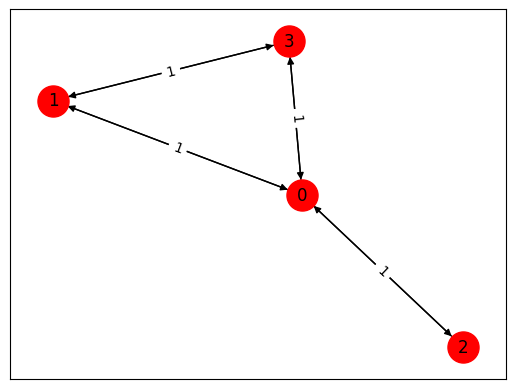

Неориентированный граф


In [6]:
# неориентированный граф
m = np.array([
    [0, 1, 1, 1],
    [1, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 1, 0, 0]
])
matrix = gb.Matrix.from_dense(m, missing_value=0)
gb.viz.draw(matrix)
print(MSBFS_Levels(matrix, np.array([0, 1, 2, 3])))

In [7]:
print(MSBFS_Parents(matrix, np.array([0, 1, 2, 3])))

Неориентированный граф


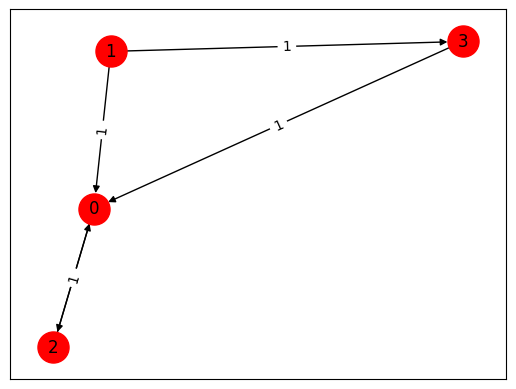

In [8]:
# ориентированный граф
m = np.array([
    [0, 0, 1, 0],
    [1, 0, 0, 1],
    [1, 0, 0, 0],
    [1, 0, 0, 0]
])
matrix = gb.Matrix.from_dense(m, missing_value=0)
gb.viz.draw(matrix)

In [9]:
print(MSBFS_Levels(matrix, np.array([0, 1, 2, 3])))

{0: array([ 0, -1,  1, -1]), 1: array([1, 0, 2, 1]), 2: array([ 1, -1,  0, -1]), 3: array([ 1, -1,  2,  0])}


In [10]:
print(MSBFS_Parents(matrix, np.array([0, 1, 2, 3])))

{0: array([-1, -2,  0, -2]), 1: array([ 1, -1,  0,  1]), 2: array([ 2, -2, -1, -2]), 3: array([ 3, -2,  0, -1])}


In [11]:
# MSBFS-Levels

# старт из 0 вершины: 1 и 3 вершины недостижимы, 2 вершина – 1 уровня
assert (MSBFS_Levels(matrix, np.array([0, 1, 2, 3]))[0]==np.array([0, -1, 1, -1])).all()
# старт из 1 вершины: 0 и 3 вершины – 1 уровня, 2 вершина – 2 уровня
assert (MSBFS_Levels(matrix, np.array([0, 1, 2, 3]))[1]==np.array([1, 0, 2, 1])).all()
# старт из 2 вершины: 1 и 3 вершины недостижимы, 0 вершина – 1 уровня
assert (MSBFS_Levels(matrix, np.array([0, 1, 2, 3]))[2]==np.array([1, -1, 0, -1])).all()
# старт из 3 вершины: 1 вершина недостижима, 0 вершина – 1 уровня, 2 вершина – 2 уровня
assert (MSBFS_Levels(matrix, np.array([0, 1, 2, 3]))[3]==np.array([1, -1, 2, 0])).all()

In [12]:
# MSBFS-Parents

# старт из 0 вершины: 1 и 3 вершины недостижимы, во 2 вершину попадаем через 0
assert (MSBFS_Parents(matrix, np.array([0, 1, 2, 3]))[0]==np.array([-1, -2, 0, -2])).all()
# старт из 1 вершины: в 0 и 3 попадаем через 1, в 2 попадаем через 0
assert (MSBFS_Parents(matrix, np.array([0, 1, 2, 3]))[1]==np.array([1, -1, 0, 1])).all()
# старт из 2 вершины: 1 и 3 вершины недостижимы, в 0 попадаем через 2
assert (MSBFS_Parents(matrix, np.array([0, 1, 2, 3]))[2]==np.array([2, -2, -1, -2])).all()
# старт из 3 вершины: 1 вершина недостижима, в 0 попадаем через 3, в 2 попадаем через 0
assert (MSBFS_Parents(matrix, np.array([0, 1, 2, 3]))[3]==np.array([3, -2,  0, -1])).all()